# Anti locking vs. Cell thickness

In cases with steep interfaces, so in one cell the interface lays at the top and in the adjacent cell at the bottom. The anti locking mechanism makes both cells active by moving $\Delta z$ to the adjecent cell. This happens without respecting the resulting imax.

In the following example three cells are modeled, with a CHD cell on the outer right. The initial water level lays above the cells and remains there during all time steps. The inital zeta is chosen such that the left cell is fully saline and the other cells contain solely freshwater. Between the left and the center cell we obnserve a steep interface.

The anit-locking mechanism transfers $\Delta z$ from $\text{cell}_0$ to the adjecent $\text{cell}_1$. For similar ssz this results in: $$ \Delta z_0 = \alpha\frac{dx_0}{dx_0 + dx_1}\frac{1}{2}(dx_0 + dx_1)\frac{1}{2}(\text{toeslope}+\text{tipslope}) $$

$\text{cell}_0$ should be able to provide this amount and $\text{cell}_1$ should be able to receive this amount. Otherwise, when zeta moves below the bottom of $\text{cell}_0$ or above the top of $\text{cell}_1$, truncation takes place. This truncation ends up in the list file as a budget error.

If a single cell has a sharp front on mutiple faces, the anti locking mechanism happens on both sides. In the second time step, the center cell has two sharp fronts, so twice the saline volume is extracted from the center cell. In the center cell this volume is not available and therefore the zeta is truncated to the bottom of the cell. In the two neighbouring cells it is possible for this saline volume to enter, in these two cells no truncation takes place.

$$\min(\text{thickness}) \approx \frac{2}{1000}\text{dx}$$

In [1]:
%reset -f
%matplotlib inline
import os
import sys
import numpy as np
import flopy.modflow as mf
import flopy.utils as fu
import matplotlib.pyplot as plt

In [2]:
os.chdir('C:\\Users\\Bas\\Google Drive\\USGS\\FloPy\\anti locking vs. cell thickness\\')
sys.path.append('C:\\Users\\Bas\\Google Drive\\USGS\\FloPy\\basScript') # location of gridObj

modelname 	= 'lockThick'
exe_name 	= 'mf2005.exe'
workspace 	= 'data\\'

In [3]:
ml = mf.Modflow(modelname, exe_name=exe_name, model_ws=workspace)

In [4]:
nstp    = 1      #[]
perlen  = 1      #[d]
ssz     = 0.2    #[]
Q       = 0.000  #[m3/d]

nper    = 3
spd     = {(0,nstp-1):['save head']}

In [5]:
nlay = 1
nrow = 1
ncol = 3
delr = 667
delc = 1.
dell = 1.

top = np.array([[-3.,-3., -1.]])
bot = np.array(top-dell).reshape((nlay,nrow,ncol))
initWL = -.5 # inital water level

In [6]:
#placing a well cell all the way on the left
lrcQ1 = np.recarray(1, dtype = mf.ModflowWel.get_default_dtype())
lrcQ1[0] = (0, 0, 0, Q) #LRCQ, Q[m**3/d]

In [7]:
lrchd = np.recarray(1, dtype = mf.ModflowChd.get_default_dtype())
lrchd[0]=(0, 0, ncol-1, initWL, initWL)

In [8]:
zini = np.array([[[-3, -4., -4.]]])
isource = np.array([[[-2.,0.,0.]]])

In [9]:
strthd = np.array([[[initWL, initWL, initWL]]])

ml = mf.Modflow(modelname, version='mf2005', exe_name=exe_name)
discret = mf.ModflowDis(ml, nrow=nrow, ncol=ncol, nlay=nlay, delr=delr, delc=delc,
                        laycbd=[0], top=top, botm=bot,
                        nper=nper, perlen=perlen, nstp=nstp)
bas = mf.ModflowBas(ml, ibound=1, strt=strthd)
bcf = mf.ModflowBcf(ml, laycon=[0], tran=[4.0])
wel = mf.ModflowWel(ml, stress_period_data={0:lrcQ1})
chd = mf.ModflowChd(ml, stress_period_data={0:lrchd})
swi = mf.ModflowSwi2(ml, nsrf=1, istrat=1, toeslope=0.02, tipslope=0.04, nu=[0, 0.025],
                     zeta=zini, ssz=ssz, isource=isource, nsolver=2)
oc  = mf.ModflowOc(ml,stress_period_data=spd)
pcg = mf.ModflowPcg(ml)

In [10]:
ml.write_input() #--write the model files

In [11]:
m = ml.run_model(silent=True, report=True)

In [12]:
headfile = modelname + '.hds'
hdobj = fu.HeadFile(headfile)
head = hdobj.get_data()

zetafile = modelname + '.zta'
zobj = fu.CellBudgetFile(zetafile)
zeta = zobj.get_data(text='      ZETASRF  1')

In [13]:
import gridobj as grd
gr = grd.gridobj(discret)
minH = 0.1*.5*delr*0.5*(swi.tipslope+swi.toeslope)
print 'Min cell height', minH
if dell < minH:
    print 'There are truncation errors being made in the tip/toe anti locking routine'
    print 'Since the cell height ( ', dell, 'm ) is less than the required cell height ( ', minH, 'm ).'
    print 'The required cell height is given by alpha*.5*delr*0.5*(swi.tipslope+swi.toeslope), if all delr and ssz are equal'

Min cell height 1.0005
There are truncation errors being made in the tip/toe anti locking routine
Since the cell height (  1.0 m ) is less than the required cell height (  1.0005 m ).
The required cell height is given by alpha*.5*delr*0.5*(swi.tipslope+swi.toeslope), if all delr and ssz are equal


isource:         [[[-2  0  0]]]
init zeta:       [[[-3. -4. -4.]]]
init fresh hd:   [[[-0.5 -0.5 -0.5]]]


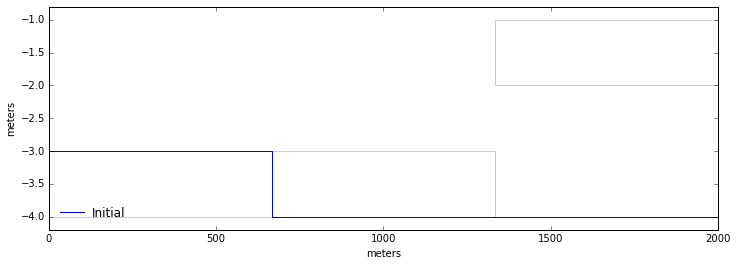

In [14]:
print 'isource:        ', swi.isource.array
print 'init zeta:      ', swi.zeta[0].array
print 'init fresh hd:  ', bas.strt.array

fig = plt.figure(figsize=(12, 4), dpi=300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
gr.plotgrLC(ax)
gr.plothdLC(ax,zini[0,:],label='Initial')
ax.axis(gr.limLC([-0.2,0.2,-0.2,0.2]))
leg = ax.legend(loc='lower left', numpoints=1)
leg._drawFrame = False

final head:      [-0.5 -0.5 -0.5]
final zeta:      [-4.00049973 -2.99950004 -2.        ]


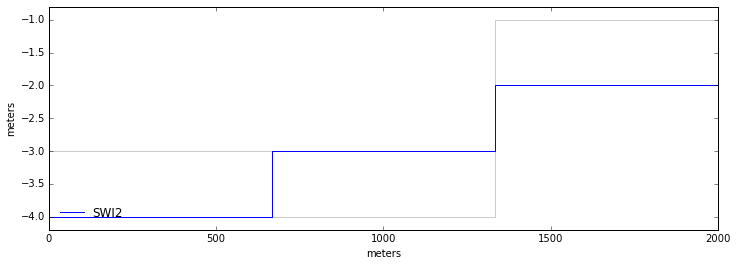

In [15]:
printiPer = 0
print 'final head:     ', head[0, 0, :]
print 'final zeta:     ', zeta[printiPer][0,0,:]

fig = plt.figure(figsize=(12, 4), dpi=300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
gr.plotgrLC(ax)
gr.plothdLC(ax,zeta[printiPer][0,0,:], label='SWI2')
ax.axis(gr.limLC([-0.2,0.2,-0.2,0.2]))
leg = ax.legend(loc='lower left', numpoints=1)
leg._drawFrame = False

final head:      [-0.5 -0.5 -0.5]
final zeta:      [-2.99999976 -4.         -0.99950004]


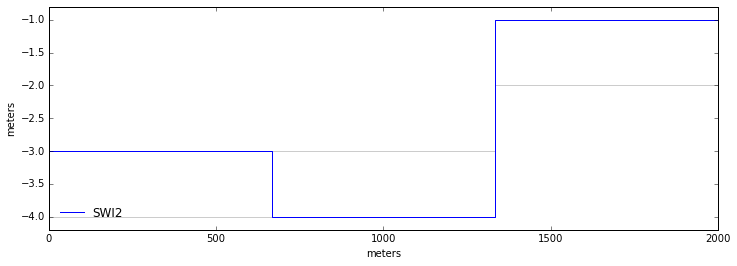

In [16]:
printiPer = 1

print 'final head:     ', head[0, 0, :]
print 'final zeta:     ', zeta[printiPer][0,0,:]

fig = plt.figure(figsize=(12, 4), dpi=300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
gr.plotgrLC(ax)
gr.plothdLC(ax,zeta[printiPer][0,0,:], label='SWI2')
ax.axis(gr.limLC([-0.2,0.2,-0.2,0.2]))
leg = ax.legend(loc='lower left', numpoints=1)
leg._drawFrame = False


final head:      [-0.5 -0.5 -0.5]
final zeta:      [-4.00049973 -2.99950004 -2.        ]


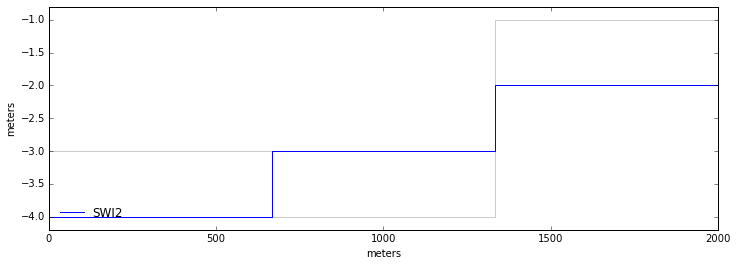

In [17]:
printiPer = 2

print 'final head:     ', head[0, 0, :]
print 'final zeta:     ', zeta[printiPer][0,0,:]

fig = plt.figure(figsize=(12, 4), dpi=300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
gr.plotgrLC(ax)
gr.plothdLC(ax,zeta[printiPer][0,0,:], label='SWI2')
ax.axis(gr.limLC([-0.2,0.2,-0.2,0.2]))
leg = ax.legend(loc='lower left', numpoints=1)
leg._drawFrame = False

In [18]:
from collections import deque
a= list(deque(open( modelname+'.list',"r" ),111))
for elem in a:
    print elem[:-1]

                                      ZONE     1
  -----------------------------------------------------------------------------------

        CUMULATIVE VOLUMES      L**3       RATES FOR THIS TIME STEP      L**3/T
        ------------------                 ------------------------

              IN:                                      IN:
              ---                                      ---
             BOUNDARIES =           0.0000            BOUNDARIES =           0.0000
          CONSTANT HEAD =           0.0000         CONSTANT HEAD =           0.0000
            ZONE CHANGE =           0.0000           ZONE CHANGE =           0.0000
       ZONE CHG TIP/TOE =         533.6667      ZONE CHG TIP/TOE =         133.4000
            ZONE MIXING =           0.0000           ZONE MIXING =           0.0000

               TOTAL IN =         533.6667              TOTAL IN =         133.4000

             OUT:                                     OUT:
             ----               